## Notebook for training ML models on dataset for Open-Source Reservoir (CMG simulations). 

Code in this notebook trains production models; it is meant to run after cross-validation.

-------

*Written by: Dmitry Duplyakin (dmitry.duplyakin@nrel.gov) in collaboration with the National Renewable Energy Laboratories.*

*Full team: Dmitry Duplyakin, Koenraad F. Beckers, Drew L. Siler, Michael J. Martin, Henry E. Johnston*

### Necessary Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import uuid
from datetime import datetime
import glob
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.metrics import mean_absolute_error
import math
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import KFold

loglevel = 'WARNING'
logging.basicConfig(level=os.environ.get("LOGLEVEL", loglevel))

# Import config file that is specific to CMG dataset
sys.path.append('../data/OpenSourceReservoir-CMG')
sys.path.append('../')

import config_cmg as config

#sys.path.append('..')
from reservoir.reservoir import Reservoir, ReservoirPredictionEnsemble

from polynomial import get_polynomial_func

%matplotlib inline
%config InlineBackend.figure_format='retina'

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

plt.style.use('ggplot')

### Loading Data (from Xcel files to Pandas dataframes)

In [2]:
import copy

cases_list = []
cases_list_for_prediction = []

data_dir = "../data/OpenSourceReservoir-CMG/"
filename_pattern = "ML_BHS_JA_*_ML_BHS_JA.xlsx"

# This assumes file names like: ../data/TETRADG-60_cases/TETRADG_v2_<case #>.xlsx
cases = dict([(int(f.split("/")[-1].replace(".xlsx","").replace("ML_BHS_JA", "").replace("_","")),f) for f 
         in glob.glob(data_dir + filename_pattern)])

for case in sorted(cases):

    file = cases[case]
    print("Processing: case %d, file %s" % (case, file))
    
    config_for_case = config
    
    # Override some config setting for this particular vis/analysis
    config_for_case.flow_unit = "kg/day"
    config_for_case.timeseries_file = file

    r = Reservoir(config_for_case, energy_calc=True)
    r_for_prediction =  Reservoir(config_for_case, energy_calc=False)
    cases_list.append(r)
    cases_list_for_prediction.append(r_for_prediction)

Processing: case 0, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00000_ML_BHS_JA.xlsx


Processing: case 1, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00001_ML_BHS_JA.xlsx
Processing: case 2, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00002_ML_BHS_JA.xlsx
Processing: case 3, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00003_ML_BHS_JA.xlsx
Processing: case 4, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00004_ML_BHS_JA.xlsx
Processing: case 5, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00005_ML_BHS_JA.xlsx
Processing: case 6, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00006_ML_BHS_JA.xlsx
Processing: case 7, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00007_ML_BHS_JA.xlsx
Processing: case 8, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00008_ML_BHS_JA.xlsx
Processing: case 9, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00009_ML_BHS_JA.xlsx
Processing: case 10, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00010_ML_BHS_JA.xlsx
Processing: case 11, file ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00011_ML_BHS_JA.xlsx
Processing: case 12, file ../d

### Manipulate Data at the Ensemble Level

In [3]:
ens = ReservoirPredictionEnsemble(config, cases_list)  
#ens.equalize_cumulative_values()
ens.scale()

# To see individual scaled timeseries, do the following:
# ens[0].scaled_timeseries

1 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 18122888.67290391
2 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 21460537.62673886
3 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 28090691.62818784
4 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 29304171.342640776
5 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 20346094.942569003
6 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 19700839.510086168
7 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 34103985.79862164
8 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 32775039.803164728
9 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 32246108.940269344
10 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 24082154.6536814
11 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 27623411.350905955
12 ../data/OpenSourceReservoir-CMG/ML_BHS_JA_00100_ML_BHS_JA.xlsx 25045663.54523

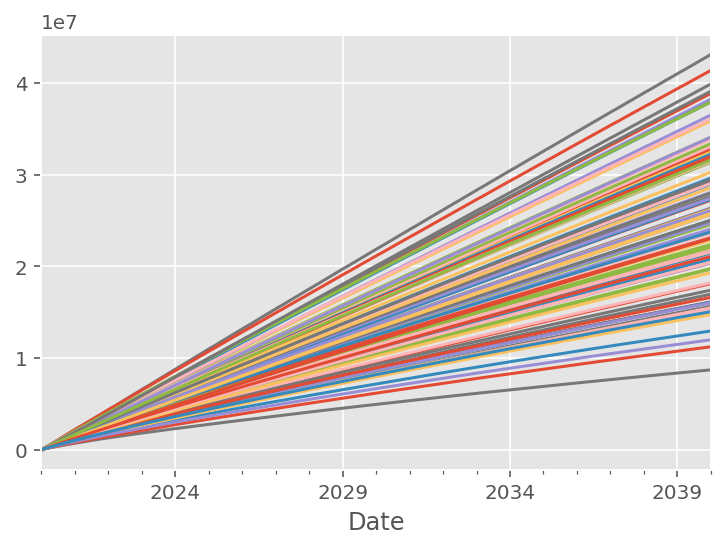

In [4]:
# Exclude case 0 becuase it covers longer period than simulated
for idx in range(1,101):
    ens[idx].energy_cumulative.plot()
    print(idx, ens[idx].config.timeseries_file, ens[idx].energy_cumulative.max())

In [5]:
ens[25].timeseries.tail(10).T

Date,2039-04-01,2039-05-01,2039-06-01,2039-07-01,2039-08-01,2039-09-01,2039-10-01,2039-11-01,2039-12-01,2040-01-01
Date,2039-04-01 00:00:00,2039-05-01 00:00:00,2039-06-01 00:00:00,2039-07-01 00:00:00,2039-08-01 00:00:00,2039-09-01 00:00:00,2039-10-01 00:00:00,2039-11-01 00:00:00,2039-12-01 00:00:00,2040-01-01 00:00:00
im1,8524703,8524703,8524703,8524703,8524703,8524703,8524703,8524703,8524703,8524703
im2,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550
im3,16473100,16473100,16473100,16473100,16473100,16473100,16473100,16473100,16473100,16473100
im4,5389298,5389298,5389298,5389298,5389298,5389298,5389298,5389298,5389298,5389298
pm1,22567590,22567590,22567590,22567590,22567590,22567590,22567590,22567590,22567590,22567590
pm2,10924640,10924640,10924640,10924640,10924640,10924640,10924640,10924640,10924640,10924640
pm3,5890355,5890355,5890355,5890355,5890355,5890355,5890355,5890355,5890355,5890355
pm4,7812033,7812033,7812033,7812033,7812033,7812033,7812034,7812033,7812034,7812033
pm5,23041870,23041870,23041870,23041870,23041870,23041870,23041870,23041870,23041870,23041870


In [7]:
ens.common_name_mapper

{'I1_Mass_Flow_Rate (kg/day)': 'im1',
 'I2_Mass_Flow_Rate (kg/day)': 'im2',
 'I3_Mass_Flow_Rate (kg/day)': 'im3',
 'I4_Mass_Flow_Rate (kg/day)': 'im4',
 'P1_Mass_Flow_Rate (kg/day)': 'pm1',
 'P2_Mass_Flow_Rate (kg/day)': 'pm2',
 'P3_Mass_Flow_Rate (kg/day)': 'pm3',
 'P4_Mass_Flow_Rate (kg/day)': 'pm4',
 'P5_Mass_Flow_Rate (kg/day)': 'pm5',
 'P6_Mass_Flow_Rate (kg/day)': 'pm6',
 'I1_Bottom-Hole_Pressure (kPa)': 'ip1',
 'I2_Bottom-Hole_Pressure (kPa)': 'ip2',
 'I3_Bottom-Hole_Pressure (kPa)': 'ip3',
 'I4_Bottom-Hole_Pressure (kPa)': 'ip4',
 'P1_Bottom-Hole_Pressure (kPa)': 'pp1',
 'P2_Bottom-Hole_Pressure (kPa)': 'pp2',
 'P3_Bottom-Hole_Pressure (kPa)': 'pp3',
 'P4_Bottom-Hole_Pressure (kPa)': 'pp4',
 'P5_Bottom-Hole_Pressure (kPa)': 'pp5',
 'P6_Bottom-Hole_Pressure (kPa)': 'pp6',
 'I1_Bottom-Hole_Temperature (C)': 'it1',
 'I2_Bottom-Hole_Temperature (C)': 'it2',
 'I3_Bottom-Hole_Temperature (C)': 'it3',
 'I4_Bottom-Hole_Temperature (C)': 'it4',
 'P1_Bottom-Hole_Temperature (C)': 'pt1',


In [8]:
quantity_list = ["im1", "im2", "im3", "im4", "pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]
for q in quantity_list:
    q_vals = []
    for idx in range(1,80):
        v = ens[idx].timeseries[q].iloc[-1]
        #v = v / (1000*24)
        q_vals.append(v)
    q_vals = np.array(q_vals)
    print(q, " -- Min and Max:", q_vals.min(), q_vals.max())

im1  -- Min and Max: 3409880 10229650
im2  -- Min and Max: 5056776 15170330
im3  -- Min and Max: 10982070 32946200
im4  -- Min and Max: 5389298 16167890
pm1  -- Min and Max: 7522530 22567590
pm2  -- Min and Max: 3641546 10924640
pm3  -- Min and Max: 3926900 11780710
pm4  -- Min and Max: 3906016 11718050
pm5  -- Min and Max: 7680623 23041870
pm6  -- Min and Max: 3555400 10666210


### Load results of cross-validation

In [5]:
batch_id = "OSR-CV"
res_dir = "../results/error_summaries/"
dest_file = os.path.join(res_dir, "batch-%s.csv" % (str(batch_id)))
loaded_results_df = pd.read_csv(dest_file)

display(loaded_results_df)

train_idx_list = loaded_results_df.train_idx.unique()
assert len(train_idx_list) == 1, "All train_idx lists in the loaded dataframe should be the same."
train_idx = train_idx_list[0].replace("[", "").replace("]", "")
train_idx = [int(x) for x in train_idx.split()]
print("Train:", train_idx)

all_idx = np.array(range(ens.count))
test_idx = sorted(list(set(all_idx).difference(set(train_idx))))
print("Test:", test_idx)

,timestamp,train_idx,quantity,degree,nn,n_epochs,loss,k,mape_list,mae_list,mape_avg,mae_avg
0,2021-11-20 20:17:09.186509,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 6]",250,mae,10,"[2.9472277975868364, 1.2782309663927875, 0.729...","[544.9526532607288, 251.63283360442176, 169.60...",0.825090,169.698494
1,2021-11-20 20:18:04.448774,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[12, 12]",250,mae,10,"[4.025413011976615, 0.9117854749115544, 0.2714...","[742.8219365677421, 179.99538816831418, 63.029...",1.002146,209.283774
2,2021-11-20 20:19:00.212845,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[16, 8]",250,mae,10,"[1.6226499053366743, 0.19672533770632084, 0.45...","[300.2119577765664, 38.9248718662849, 107.1910...",0.861885,179.904075
3,2021-11-20 20:19:56.498958,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[16, 16]",250,mae,10,"[3.07655447568534, 2.4734963061311612, 0.89370...","[565.262644241023, 486.5495099534298, 207.8991...",0.963397,197.735710
4,2021-11-20 20:20:53.204994,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pp1,4,"[24, 12]",250,mae,10,"[1.9225395815914408, 1.062757760639499, 2.5390...","[355.6594014893129, 209.5790974638095, 596.665...",1.032800,214.824486
...,...,...,...,...,...,...,...,...,...,...,...,...
859,2021-11-22 10:31:16.948318,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[16, 16]",1000,mae,10,"[0.48908020127712326, 3.4120722664008625, 0.80...","[0.879524876516643, 5.87051704763204, 1.274687...",3.358269,5.313810
860,2021-11-22 10:35:00.157749,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[24, 12]",1000,mae,10,"[1.327495971869418, 1.1446399256315818, 3.2709...","[2.3938139558196987, 1.972434676257694, 5.1608...",2.652577,4.149031
861,2021-11-22 10:38:48.760874,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[24, 24]",1000,mae,10,"[1.6530775244611398, 2.6608913165810084, 2.773...","[2.9794983521802623, 4.563748573868892, 4.3704...",3.305686,5.066085
862,2021-11-22 10:42:41.266494,[ 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 ...,pt6,6,"[32, 16]",1000,mae,10,"[1.4354629368461296, 1.3340178619654213, 1.162...","[2.58722602797342, 2.2920010978185124, 1.83405...",3.257627,5.107888


Train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99]
Test: [17, 36, 52, 55, 78, 82, 83, 85, 94, 95, 100]


### Model Training and Evaluation

train: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 84, 86, 87, 88, 89, 90, 91, 92, 93, 96, 97, 98, 99], test: [17, 36, 52, 55, 78, 82, 83, 85, 94, 95, 100]


,im1,im2,im3,im4,pm1,pm2,pm3,pm4,pm5,pm6
0,0.43091,0.639029,1.38781,0.681051,0.950629,0.460185,0.496246,0.493607,0.970607,0.449299
1,0.43091,0.479272,1.73477,0.510788,0.950629,0.690278,0.496246,0.370205,0.485303,0.224649
2,0.43091,0.319515,1.38781,0.681051,1.18829,0.230093,0.620308,0.493607,0.485303,0.22465
3,0.323182,0.798787,1.73477,0.340525,1.18829,0.345139,0.620308,0.370205,0.970607,0.561624
4,0.646365,0.479272,1.04086,1.02158,1.18829,0.575232,0.248123,0.617009,1.21326,0.336975
...,...,...,...,...,...,...,...,...,...,...
96,0.215455,0.639029,1.38781,0.340525,0.475314,0.575232,0.744369,0.246803,0.970607,0.4493
97,0.646365,0.319515,1.38781,0.510788,0.950629,0.690278,0.496246,0.246804,1.21326,0.561624
98,0.646365,0.639029,1.38781,0.340525,0.475314,0.230093,0.744369,0.370205,1.21326,0.22465
99,0.215455,0.958544,1.73477,0.340525,0.712971,0.345139,0.620308,0.246803,0.970607,0.561624


Quantity: pp1
Quantity: pp2
Quantity: pp3
Quantity: pp4
Quantity: pp5
Quantity: pp6
Quantity: pt1
Quantity: pt2
Quantity: pt3
Quantity: pt4
Quantity: pt5
Quantity: pt6


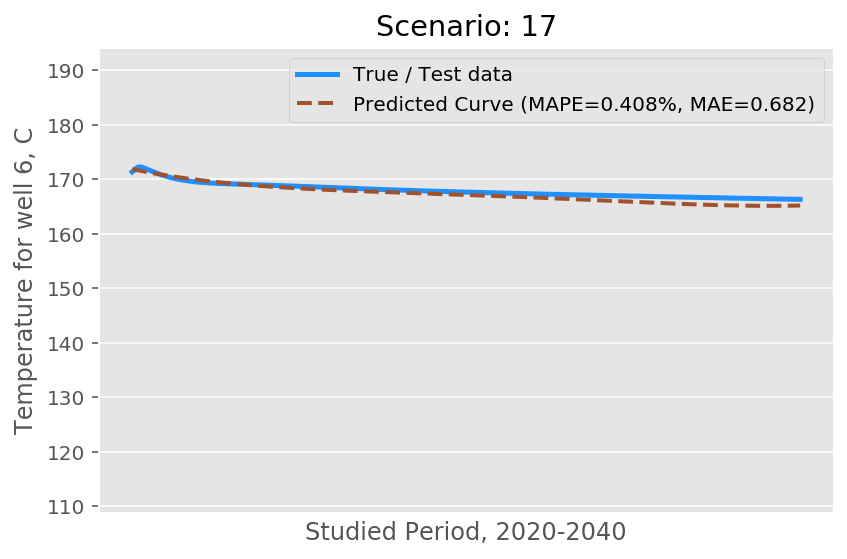

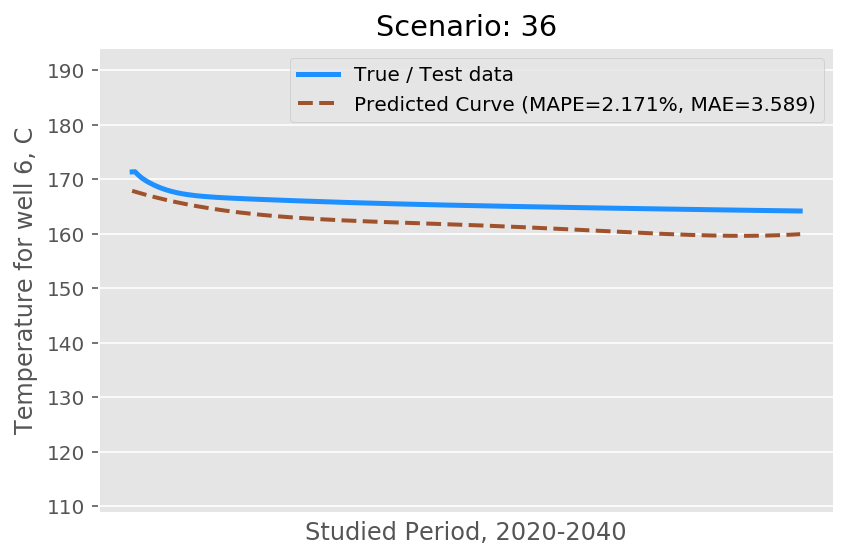

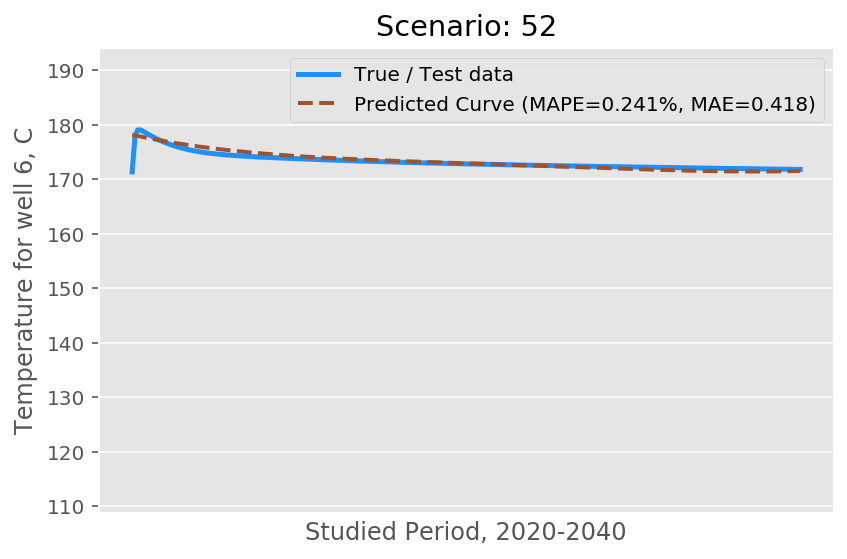

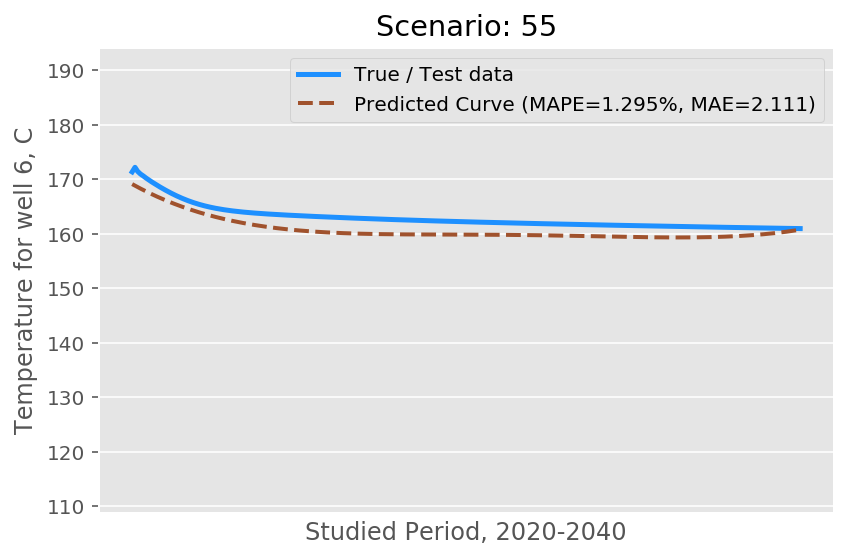

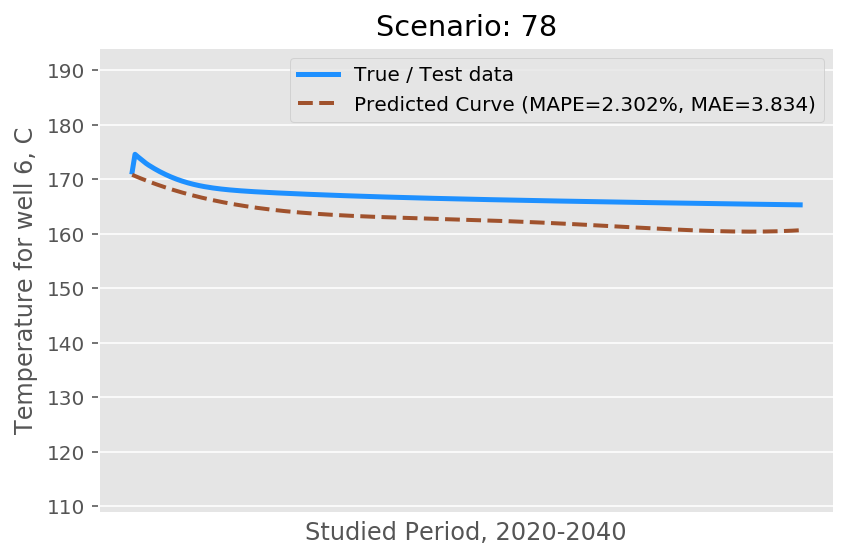

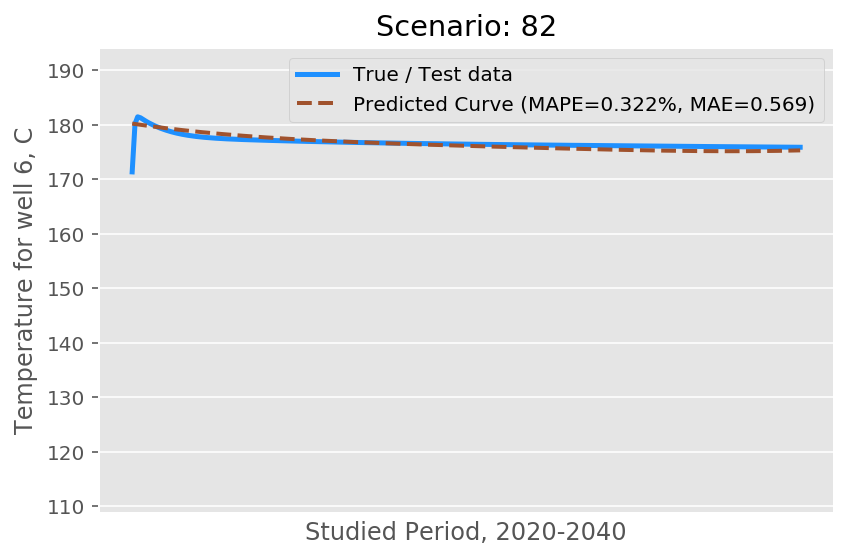

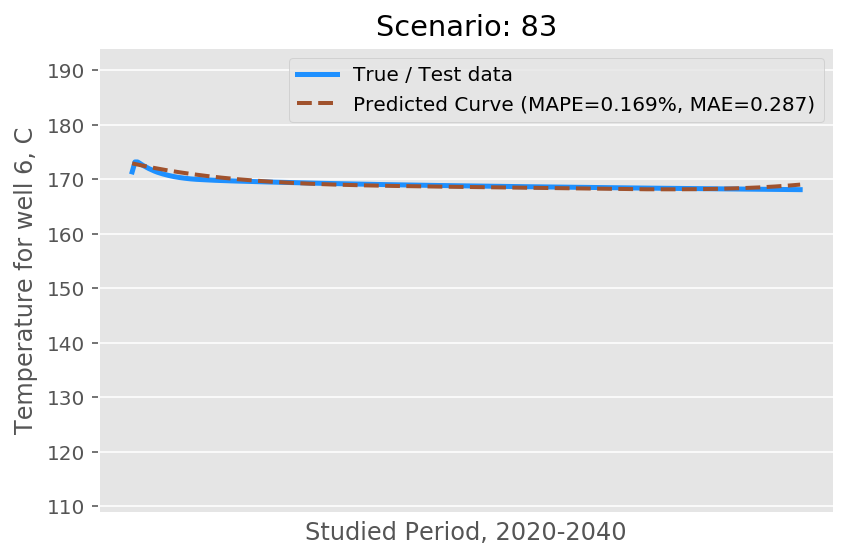

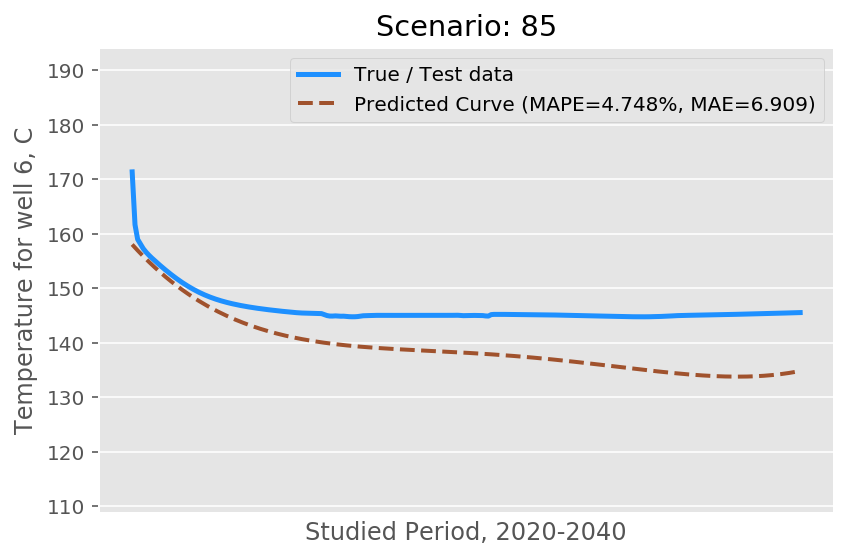

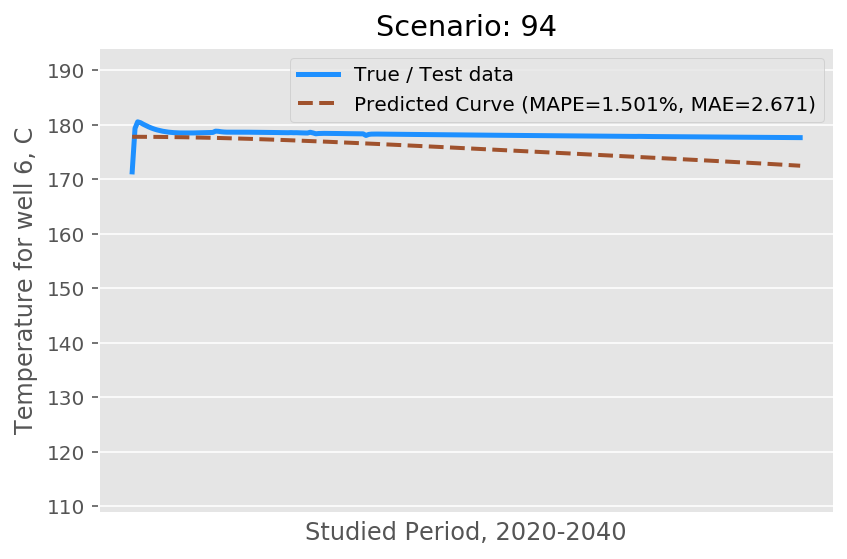

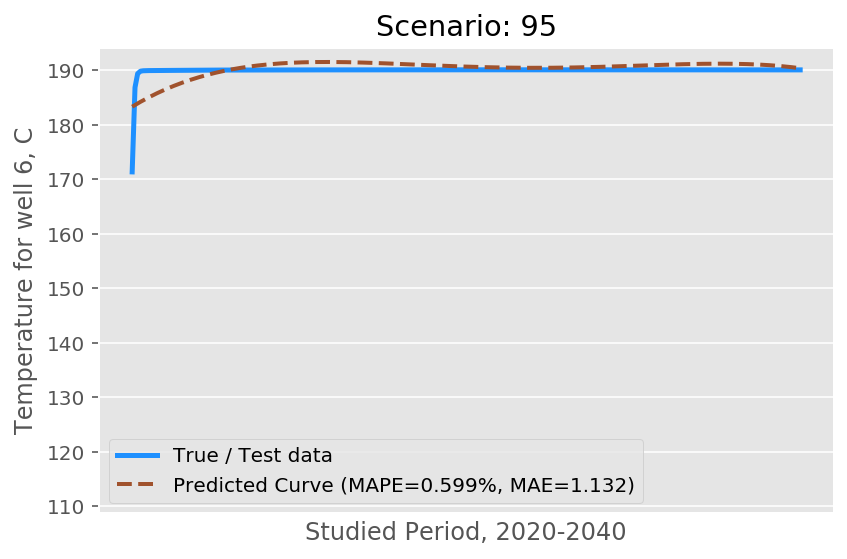

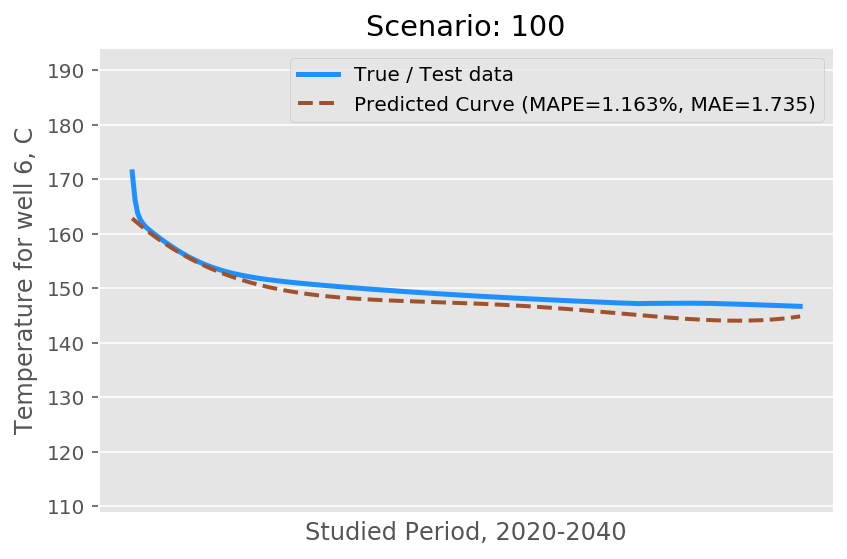

,timestamp,train_idx,quantity,degree,nn,n_epochs,loss,mape_list,mae_list,mape_avg,mae_avg
0,2021-12-02 20:48:41.991920,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp1,4,"[12, 6]",1000,mae,"[0.5110016194115736, 0.19952170305554046, 0.34...","[105.67751173793492, 40.95428341501146, 71.268...",0.373672,77.452606
1,2021-12-02 20:49:04.686061,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp2,4,"[12, 6]",1000,mae,"[1.036531380355017, 1.0656218826542458, 1.1358...","[118.05581816648798, 122.36519742021115, 134.3...",1.197473,125.490833
2,2021-12-02 20:49:27.983746,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp3,4,"[12, 6]",1000,mae,"[0.26473708261125545, 0.2419387972746959, 0.31...","[33.78022765808033, 31.1073363185073, 41.51706...",0.479143,58.245666
3,2021-12-02 20:49:51.183925,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp4,4,"[12, 6]",1000,mae,"[0.7421688526603878, 0.19294554593649774, 0.66...","[84.31993673921019, 22.11813621220504, 79.0176...",0.575293,64.922472
4,2021-12-02 20:50:14.913478,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp5,4,"[12, 6]",1000,mae,"[0.24166078212532446, 0.4980879870990453, 0.26...","[55.11866562713263, 112.86208459907397, 61.743...",0.416758,93.882134
5,2021-12-02 20:50:38.378280,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pp6,4,"[12, 6]",1000,mae,"[0.5734063242493842, 0.34602620072303664, 0.49...","[130.7396087777629, 78.36705763401105, 113.716...",0.407243,92.604285
6,2021-12-02 20:51:01.935883,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pt1,4,"[12, 6]",1000,mae,"[1.4069735100787186, 2.7923563631984205, 2.033...","[1.5573090603896438, 2.9243074011338703, 2.199...",2.032471,2.202829
7,2021-12-02 20:51:26.041595,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pt2,4,"[12, 6]",1000,mae,"[1.202906295889828, 0.3411942241090495, 0.4134...","[1.1066041314038395, 0.29286945108276174, 0.35...",0.650874,0.589660
8,2021-12-02 20:51:49.471478,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pt3,4,"[12, 6]",1000,mae,"[0.25950471228471156, 0.5412885691432244, 0.51...","[0.2812216480481227, 0.5643193556729645, 0.523...",0.846532,0.907262
9,2021-12-02 20:52:12.891213,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",pt4,4,"[12, 6]",1000,mae,"[1.6752751362081235, 0.7131091412870761, 1.180...","[2.2262263630558707, 0.869046037649988, 1.4364...",1.477549,1.744326


In [6]:
# Reduce randomness in results by setting the seed
tf.random.set_seed(4)

##########################
# Setting key parameters #
##########################

batch_id = "OSR-CV-Production"

loss = "mae" # mae or mse
validation_split_ratio = 0.0 # Ratio of train set that will be treated as validation set

k = 10 # k for k-fold validation

plotting = True

res_dir = "../results/error_summaries/"
model_dir = "../models/"

save_to_disk = False

quantity_list = ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6", "pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]
degree = 4
nn = [12, 6]
n_epochs = 1000   

# New results will be *appended* to this file
dest_file = os.path.join(res_dir, "batch-%s.csv" % (str(batch_id)))

required_results_df_columns = ["timestamp", "train_idx", "quantity", "degree", "nn", "n_epochs", "loss", "mape_list", "mae_list", "mape_avg", "mae_avg"]                        
    
##################################
# All key parameters are set now #
##################################

##################################
# Routine for model fitting      #
##################################

def fit_custom_model(X_train, Y_train, nn, loss, n_epochs):
    
    assert len(nn) == 2, "nn: should be a list with *two* layer sizes"
    nn1, nn2 = nn
    
    # initialize model
    model = Sequential()

    # add 1st layer
    model.add(Dense(
        units=nn1,
        input_dim=X_train.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh') 
    )
    # add 2nd layer
    model.add(
        Dense(
            units=nn2,
            input_dim=nn1,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            activation='tanh')
        )
    # add output layer
    model.add(
        Dense(
            units=Y_train.shape[1],
            input_dim=nn2,
            kernel_initializer='glorot_uniform',
            bias_initializer='zeros',
            activation=None)
        )

    # define SGD optimizer
    sgd_optimizer = SGD(
        lr=0.001, decay=1e-7, momentum=0.9
    )
    
    # compile model
    model.compile(
        optimizer=sgd_optimizer,
        loss=loss
    )

    X_train_converted=np.asarray(X_train).astype(np.float32)
    Y_train_converted=np.asarray(Y_train).astype(np.float32)

    #print(model.summary())

    #train model; validation_split=0.0 because CV is already handled outside of this training routine
    training_history = model.fit(
        X_train_converted, Y_train_converted,
        batch_size=1, 
        epochs=n_epochs,
        verbose=0, 
        validation_split=0.0
    )
    return model, training_history

#################################### 
# End of Routine for model fitting #
####################################

trained_models_dict = {}

# This predicted ensemble object will be populated with predicted timeseries values, scaled and unscaled
ens_predicted = ReservoirPredictionEnsemble(config, cases_list_for_prediction)  

# Train and Test indices are already defined in a cell above
print('train: %s, test: %s' % (train_idx, test_idx))

# Form a dataframe with all controlled parameter values
m_column_list = ["im1", "im2", "im3", "im4"]
injector_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].scaled_timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        injector_df.at[i, c] = df[c].value_counts().index[0]

m_column_list = ["pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]
producer_df = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].scaled_timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        producer_df.at[i, c] = df[c].value_counts().index[0]

all_wells_df = injector_df.join(producer_df)
display(all_wells_df)

poly = get_polynomial_func(degree=degree)

results_df = pd.DataFrame(columns = required_results_df_columns)

for quantity in quantity_list:
    print("Quantity:", quantity)

    if quantity in ["pp1", "pp2", "pp3", "pp4", "pp5", "pp6"]:
        scaler = ens.common_pres_scaler
    elif quantity in ["pt1", "pt2", "pt3", "pt4", "pt5", "pt6"]:
        scaler = ens.common_temp_scaler

    t_mapper = ens.shared_scaled_time_index(start_at='2020-01-01')
    #t_mapper = {k: v+1.0 for k,v in t_mapper.items()}

    ydata_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))
    yhat_df = pd.DataFrame(index=sorted(t_mapper.values()), columns=range(ens.count))

    coeff_df, _, quantity_min_max = ens.get_curve_approximations(quantity, poly)

    #display(coeff_df)

    #print("Input for Curve ML training:")
    X_train = all_wells_df.loc[train_idx]
    #display(X_train)

    #print("Output for Curve ML training:")
    Y_train = coeff_df.loc[train_idx]
    #display(Y_train)

    X_test = all_wells_df.loc[test_idx]
    Y_test = coeff_df.loc[test_idx]

    model, training_history = fit_custom_model(X_train, Y_train, nn, loss, n_epochs)

    trained_models_dict[quantity] = model
    
    # Random UUID
    model_uuid = uuid.uuid4()
    if save_to_disk:
        model.save(os.path.join(model_dir, str(model_uuid)))

    X_test=np.asarray(X_test).astype(np.float32)
    Y_test=np.asarray(Y_test).astype(np.float32)

    # Predicted coefficients
    Y_test_pred = model.predict(X_test, verbose=0)

    xdata = np.linspace(0, 1.0, 50) # point along scaled time dimension

    mape_list, mae_list = [], []
    for coeff_true, coeff_pred, test_case_id in zip(Y_test, Y_test_pred, test_idx):
        one_traj = ens[test_case_id].scaled_timeseries[quantity]
        one_traj = one_traj[one_traj.index >= pd.to_datetime('2020-01-01')]
        xdata_for_true_data = np.array(one_traj.index.map(t_mapper))
        ydata_not_fitted = one_traj.values

        ydata_true = poly(xdata, *coeff_true)
        ydata_pred = poly(xdata, *coeff_pred)
        ydata_pred_for_error_est = poly(xdata_for_true_data, *coeff_pred)

        # Perform error analysis on unscaled data
        ydata_not_fitted_unscaled = scaler.inverse_transform(ydata_not_fitted.reshape(-1, 1)).reshape(-1,)
        ydata_pred_for_error_est_unscaled = scaler.inverse_transform(ydata_pred_for_error_est.reshape(-1, 1)).reshape(-1,)
        mape = mean_absolute_percentage_error(ydata_not_fitted_unscaled, ydata_pred_for_error_est_unscaled)
        mae = mean_absolute_error(ydata_not_fitted_unscaled, ydata_pred_for_error_est_unscaled)

        mape_list.append(mape)
        mae_list.append(mae)
        
        if plotting:
            if quantity == "pt6":
                plt.plot(xdata_for_true_data, 
                     ydata_not_fitted_unscaled, 
                     '-', c="dodgerblue", label="True / Test data", linewidth=2.5)
                plt.plot(xdata_for_true_data, 
                     ydata_pred_for_error_est_unscaled, 
                     '--', c="sienna", label="Predicted Curve (MAPE=%.3f%%, MAE=%.3f)" % (mape, mae), linewidth=2.0)

                quantity_min_max_row = quantity_min_max[quantity_min_max["quantity"] == quantity]
                if len(quantity_min_max_row) == 1:
                    qmin = quantity_min_max_row["quantity_min"].values[0]
                    qmax = quantity_min_max_row["quantity_max"].values[0]
                    qrange = qmax - qmin
                    plt.ylim([qmin-qrange*0.05, qmax+qrange*0.05])
                plt.legend()
                #plt.title("Quantity: %s, Scenario: %s" % (quantity, test_case_id))
                plt.title("Scenario: %s" % (test_case_id))
                
                ax = plt.gca()
                ax.axes.xaxis.set_ticks([])
                ax.set_xlabel("Studied Period, 2020-2040")
                ax.set_ylabel("Temperature for well 6, C")
                plt.savefig("../figures/" + "true_vs_pres-%s-%s.png" % (quantity, str(test_case_id)), dpi=300)
                plt.tight_layout()
                plt.show()

        #ens_predicted[test_case_id].scaled_timeseries[quantity] = ydata_pred_for_error_est
        ens_predicted[test_case_id].timeseries[quantity] = ydata_pred_for_error_est_unscaled

    now = datetime.now()
    results_df.loc[len(results_df)] = [
        now, 
        train_idx,
        quantity, degree, nn, n_epochs, loss, 
        mape_list, mae_list, np.array(mape_list).mean(), np.array(mae_list).mean()]

display(results_df)

### Summarize and visualize prediction error estimates (MAPE)

,quantity,mape
0,Pressure for well 1,0.511002
1,Pressure for well 1,0.199522
2,Pressure for well 1,0.340072
3,Pressure for well 1,0.359910
4,Pressure for well 1,0.208674
...,...,...
6,Temperature for well 6,0.169310
7,Temperature for well 6,4.747733
8,Temperature for well 6,1.500840
9,Temperature for well 6,0.598513


Summary of MAPE values for Pressure:
 count    66.000000
mean      0.574930
std       0.518947
min       0.132940
25%       0.274132
50%       0.419246
75%       0.667060
max       3.679236
Name: mape, dtype: float64
Summary of MAPE values for Temperature:
 count    66.000000
mean      1.336541
std       1.069492
min       0.169310
25%       0.435859
50%       1.171744
75%       1.696189
max       4.747733
Name: mape, dtype: float64


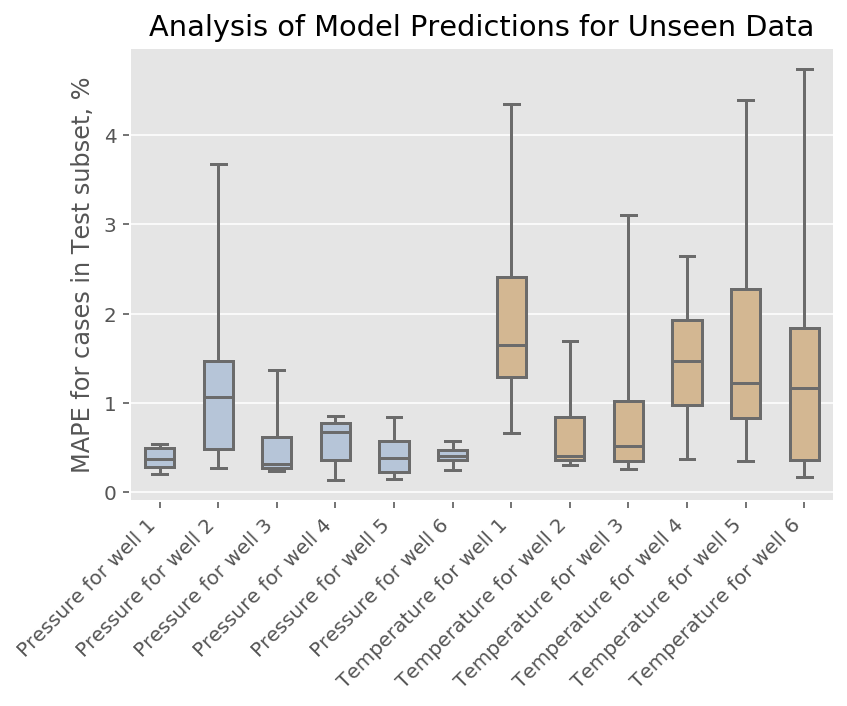

In [7]:
to_plot = pd.DataFrame()
for idx, row in results_df.iterrows(): 
    to_plot = pd.concat([to_plot, pd.DataFrame({"quantity": row["quantity"], 
                                                "mape": row.mape_list})])
#print(to_plot.quantity.value_counts())

renaming_dict = {x : "Pressure for well " + x[-1] if "pp" in x else "Temperature for well " + x[-1] for x in to_plot.quantity.unique()}
to_plot.quantity = to_plot.quantity.map(renaming_dict)
display(to_plot)

print ("Summary of MAPE values for Pressure:\n", to_plot[to_plot.quantity.apply(lambda x: "Pressure" in x)].mape.describe())
print ("Summary of MAPE values for Temperature:\n", to_plot[to_plot.quantity.apply(lambda x: "Temperature" in x)].mape.describe())



fig, ax = plt.subplots(figsize=(6, 5))
sns.boxplot(x="quantity", y="mape", data=to_plot,
            whis=[0, 100], width=.5, palette=["lightsteelblue"] * 6 + ["burlywood"] * 6,
            ax=ax)
ax.set_xlabel("");
plt.xticks(rotation = 45, ha='right')
ax.set_ylabel("MAPE for cases in Test subset, %");
ax.set_title("Analysis of Model Predictions for Unseen Data")
plt.tight_layout()
plt.savefig("../figures/" + "test_mape_for_all_quantities_boxplot.png", dpi=300)
plt.show();

### Evaluate energy and exergy predictions

In [8]:
# Iterate over all cases

for test_case_id in test_idx:
    print("Processing:", test_case_id)
    ens_predicted[test_case_id].estimate_energy_and_exergy()
    ens_predicted[test_case_id].calculate_cumulative()
    ens[test_case_id].calculate_cumulative()

Processing: 17
Processing: 36
Processing: 52
Processing: 55
Processing: 78
Processing: 82
Processing: 83
Processing: 85
Processing: 94
Processing: 95
Processing: 100


Processing: 17
Processing: 36
Processing: 52
Processing: 55
Processing: 78
Processing: 82
Processing: 83
Processing: 85
Processing: 94
Processing: 95
Processing: 100


,test_id,percentage_error
0,17.0,-0.680268
1,36.0,0.489126
2,52.0,0.381978
3,55.0,2.309646
4,78.0,0.172416
5,82.0,1.274307
6,83.0,-0.442433
7,85.0,-0.293186
8,94.0,-0.963182
9,95.0,4.043919


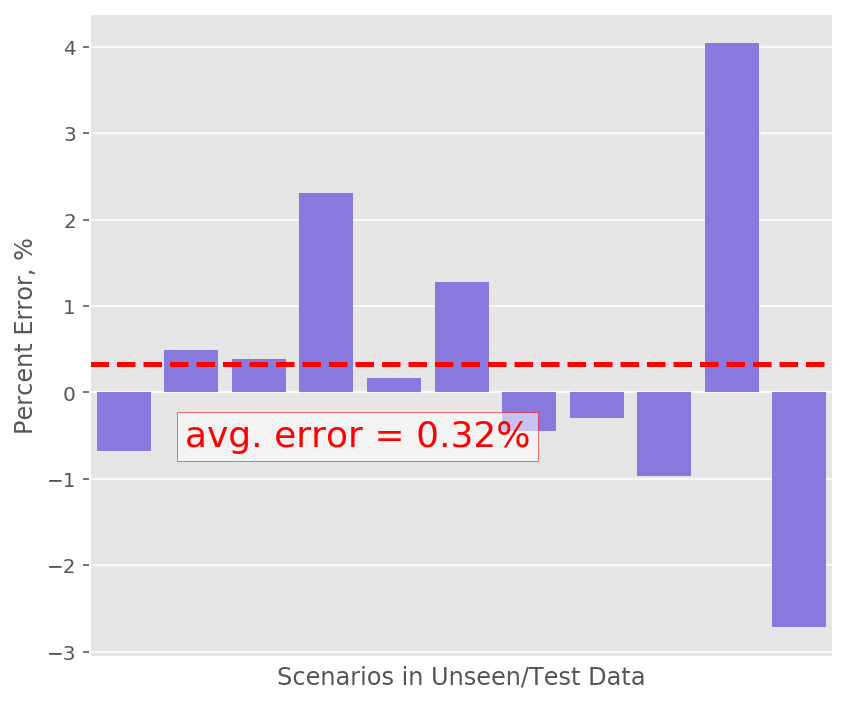

In [9]:
from sklearn.metrics import mean_squared_error
import math


energy_pred_err_df = pd.DataFrame(columns=["test_id", "percentage_error"])
for test_case_id in test_idx:
    print("Processing:", test_case_id)
    true_energy_max = ens[test_case_id].energy_cumulative.max()
    pred_energy_max = ens_predicted[test_case_id].energy_cumulative.max()
#     mape = mean_absolute_percentage_error(true_energy[true_energy > 0], pred_energy[pred_energy > 0])
#     MSE = mean_squared_error(true_energy, pred_energy)
#     rmse = math.sqrt(MSE)
#     print(mape)
#     print(rmse)

    p_diff = (true_energy_max - pred_energy_max) / true_energy_max * 100.0
    energy_pred_err_df.loc[len(energy_pred_err_df)] = [test_case_id, p_diff]

display(energy_pred_err_df)

fig, ax = plt.subplots(figsize=(6, 5))

err_mean = energy_pred_err_df.percentage_error.mean()
ax.axhline(err_mean, linestyle='--', lw=2.5, c='red')
ax.set_ylabel("Relative Error, %")
t=ax.annotate('avg. error = %.2f%%' % err_mean, xy=(0.9, err_mean-0.95),  xycoords='data', fontsize=18, color="red") #, xytext=(ens.count, err_mean))
t.set_bbox(dict(facecolor='white', alpha=0.55, edgecolor='red'))

sns.barplot(x="test_id", y="percentage_error", data=energy_pred_err_df, color="mediumslateblue", ax=ax)
ax.set_xlabel("Scenarios in Unseen/Test Data")
ax.set_ylabel("Percent Error, %")
ax.set_xticks([])
plt.tight_layout()
plt.savefig("../figures/" + "energy_pred_errors_barplots.png", dpi=300)
plt.show()

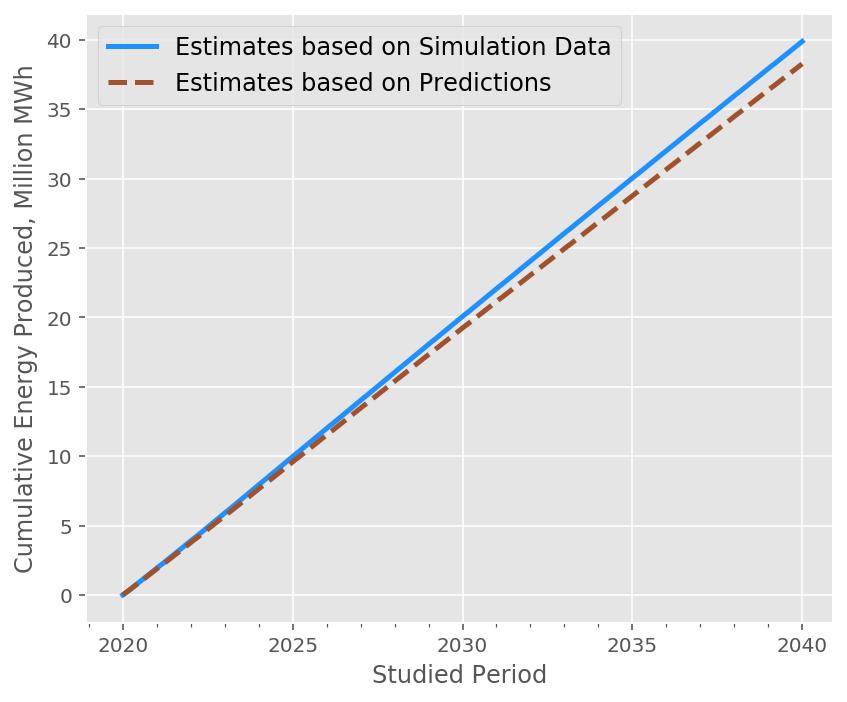

In [10]:
fig, ax = plt.subplots(figsize=(6, 5))
true_energy = ens[95].energy_cumulative.copy()
true_energy = true_energy / 10**6
true_energy.plot(linestyle="-", linewidth=2.5, color="dodgerblue", label="Estimates based on Simulation Data",
                               ax=ax)
pred_energy = ens_predicted[95].energy_cumulative.copy()
pred_energy = pred_energy / 10**6
pred_energy.plot(linestyle="--", linewidth=2.5, color="sienna", label="Estimates based on Predictions",
                                         ax=ax)

t_range = ens_predicted[95].energy_cumulative.index[-1] - ens_predicted[95].energy_cumulative.index[0]
ax.set_xlim(ens_predicted[95].energy_cumulative.index[0] - t_range / 20.0,
ens_predicted[95].energy_cumulative.index[-1] + t_range / 20.0)

ax.set_xticks(ticks=ens_predicted[95].energy_cumulative.index[::60].tolist())
ax.set_xticklabels([x.year for x in ens_predicted[95].energy_cumulative.index[::60]])
ax.set_xlabel("Studied Period")

ax.ticklabel_format(style='plain', axis='y')

ax.set_ylabel("Cumulative Energy Produced, Million MWh")
ax.legend(fontsize=12)
plt.tight_layout()
plt.savefig("../figures/" + "one_cumulative_energy_pred.png", dpi=300)
plt.show()

In [11]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 12)                132       
_________________________________________________________________
dense_34 (Dense)             (None, 6)                 78        
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 35        
Total params: 245
Trainable params: 245
Non-trainable params: 0
_________________________________________________________________


### Sensitivity Analysis

* https://www.sciencedirect.com/science/article/pii/S0920410520306975
Talks about sensitivity index (classical one-at-a-time sensitivity index)

In [12]:
import logging

# Flip this flag to enable/disable printing of debug info
debug = False 

# Configure logging according to the choice above
LOG = logging.getLogger(__name__)  
if debug: 
    LOG.setLevel(logging.DEBUG)
else:
    LOG.setLevel(logging.INFO)


# Define a function that implments prediction and post-processing, as well as handles optional display and visualization

def run_predictions_osr(flows, config, trained_models_dict, ens, display_yearly=True, vis=True):
    inv_mapper = {v: k for k, v in ens.common_name_mapper.items()}
    
    
    LOG.debug("Selected flows before name mapping:\n%s" % str(flows))
    # ---------------

    # Prepare reservoir object for predictions
    r_for_prediction =  Reservoir(config, energy_calc=False)
    
    mapped_flows = {}
    for k,v in flows.items():
        mapped_flows[r_for_prediction.name_mapper[k]] = v
    LOG.debug("Selected flows after name mapping:\n%s" % str(mapped_flows))

    # Prepare ensemble object (with a single scenario) for predictions
    for c in r_for_prediction.all_producer_flow + r_for_prediction.all_injector_flow:
        v = mapped_flows[c]
        r_for_prediction.timeseries[c] = v
    ens_for_prediction = ReservoirPredictionEnsemble(config, [r_for_prediction])
    # Rather than using its own scalers, use the scalers from ensemble with loaded simulation data
    ens_for_prediction.scale(scalers=\
                 {"temp": ens.common_temp_scaler,
                  "pres": ens.common_pres_scaler,
                  "flow": ens.common_flow_scaler})

    # This countrols specific order of variables in the input for ML (order is important)
    all_flows_ordered = r_for_prediction.all_injector_flow + r_for_prediction.all_producer_flow
    flows_df = pd.DataFrame(columns=all_flows_ordered, index=[0])
    # It is important to use *scaled* values rather than unscaled here
    for c in all_flows_ordered:
        flows_df.iloc[0][c] = ens_for_prediction[0].scaled_timeseries[c][0]
    LOG.debug("Flows dataframe (with scaled values):\n%s" % str(flows_df))

    # Prepare input for tensorflow models
    entire_set = sorted(flows_df.index.tolist())
    X_test = flows_df.loc[entire_set]
    X_test=np.asarray(X_test).astype(np.float32)

    t_mapper = ens_for_prediction.shared_scaled_time_index(start_at='2020-01-01')

    # Go through all quantities that need to be predicted (the same as the list of loaded models)
    for q in sorted(trained_models_dict.keys()):

        if q in r_for_prediction.all_producer_pres:
            scaler = ens_for_prediction.common_pres_scaler
        elif q in r_for_prediction.all_producer_temp:
            scaler = ens_for_prediction.common_temp_scaler

        degree = 4
        poly = get_polynomial_func(degree=degree)

        # Models are already loaded so use one from the existing dictionary
        model = trained_models_dict[q]

        # Predicted coefficients
        Y_test_pred = model.predict(X_test, verbose=0)
        LOG.debug("Predicted coefficients for %s:\n%s" % (q, str(Y_test_pred)))

        for coeff_pred, test_case_id in zip(Y_test_pred, entire_set):

            traj = ens_for_prediction[test_case_id].scaled_timeseries[q]
            traj = traj[traj.index >= pd.to_datetime('2020-01-01')]
            xdata = np.array(traj.index.map(t_mapper))

            ydata_pred = poly(xdata, *coeff_pred)

            ens_for_prediction[test_case_id].scaled_timeseries[q] = ydata_pred

            ydata_pred_unscaled = scaler.inverse_transform(ydata_pred.reshape(-1, 1)).reshape(-1,)
            ens_for_prediction[test_case_id].timeseries[q] = ydata_pred_unscaled

    LOG.debug("Predicted (scaled) values for pressures & temperatures:\n%s" % \
              str(ens_for_prediction[0].scaled_timeseries[sorted(trained_models_dict.keys())]))

    ens_for_prediction[0].estimate_energy_and_exergy()
    ens_for_prediction[0].calculate_cumulative()

    #print("Predicted (unscaled) values for pressures & temperatures (showing first record for each year):")
    #old_row_max = pd.options.display.max_rows
    #pd.set_option('display.max_rows', None)
    # Select only predicted columns
    pres_and_temp_df = ens_for_prediction[0].timeseries[sorted(trained_models_dict.keys())]
    # Map back column names to the original names
    pres_and_temp_df.columns = [inv_mapper[c] for c in pres_and_temp_df.columns]
    # Pull out years from all timestamps
    year_series = pd.Series([row_date.year for row_date in pres_and_temp_df.index])
    # This creates an index with *first records for every year* (shift() is used to find rows where one year ends and the following year begins)
    year_index = year_series[year_series != year_series.shift()].index
    #display(pres_and_temp_df.iloc[year_index])
    #pd.set_option('display.max_rows', old_row_max)

    # Pull out pressure and temperature predictions
    pressure_df = pres_and_temp_df[[c for c in pres_and_temp_df.columns if "PAV" in c]]
    if display_yearly:
        print("Predicted pressures (showing first record for each year):")
        display(pressure_df.iloc[year_index])
    temperature_df = pres_and_temp_df[[c for c in pres_and_temp_df.columns if "TAV" in c]]
    if display_yearly:
        print("Predicted temperatures (showing first record for each year):")
        display(temperature_df.iloc[year_index])

    # Create dataframe with exergy and energy predictions
    exergy_and_energy_df = pd.DataFrame({"Cumulative Exergy (MWh)": ens_for_prediction[0].exergy_cumulative, 
                                         "Cumulative Energy (MWh)": ens_for_prediction[0].energy_cumulative})
    if display_yearly:
        print("Cumulative exergy and energy in MWh (showing first record for each year):")
        display(exergy_and_energy_df.iloc[year_index])

    # Visualizations
    if vis:
        plt.style.use('ggplot')
        plt.rcParams.update({'font.size': 14})
        
        fig1 = temperature_df.plot(figsize=(18,4))
        ax1 = fig1.axes
        # Shrink current axis by 20% & put a legend to the right of the current axis
        box = ax1.get_position()
        ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        fig2 = pressure_df.plot(figsize=(18,4))
        ax2 = fig2.axes
        # Shrink current axis by 20% & put a legend to the right of the current axis
        box = ax2.get_position()
        ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        fig3 = exergy_and_energy_df.plot(figsize=(18,4));
        fig3.set_ylabel("MWh");
        ax3 = fig3.axes
        # Shrink current axis by 20% & put a legend to the right of the current axis
        box = ax3.get_position()
        ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        
    return pres_and_temp_df, exergy_and_energy_df 

In [13]:
ens[0].timeseries[["im1", "im2", "im3", "im4", "pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]].iloc[-1]

im1     6819763.0
im2    10113550.0
im3    21964140.0
im4    10778600.0
pm1    15045060.0
pm2     7283092.0
pm3     7853804.0
pm4     7812034.0
pm5    15361250.0
pm6     7110808.0
Name: 2040-01-01 00:00:00, dtype: float64

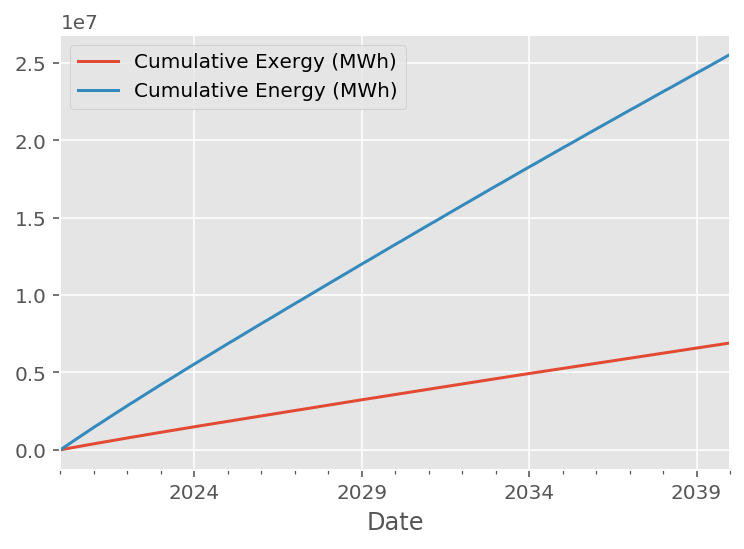

In [14]:
# This cell can be used for performance measurements -- it will run a number of single-case predictions and output stats for the runtime (in seconds)  
# Time estimates obtained here can be used to plan running predictions for a large batch of cases (e.g., one can estimate how many cases can be evaluated in 1h). 

# Select a specific combination of flow values for which the code will produce predictions using the trained models 
flows = {\
  'P1_Mass_Flow_Rate (kg/day)': 15045060.0,\
  'P2_Mass_Flow_Rate (kg/day)': 7283092.0,\
  'P3_Mass_Flow_Rate (kg/day)': 7853804.0,\
  'P4_Mass_Flow_Rate (kg/day)': 7812034.0,\
  'P5_Mass_Flow_Rate (kg/day)': 15361250.0,\
  'P6_Mass_Flow_Rate (kg/day)': 7110808.0,\
  'I1_Mass_Flow_Rate (kg/day)': 6819763.0,\
  'I2_Mass_Flow_Rate (kg/day)': 10113550.0,\
  'I3_Mass_Flow_Rate (kg/day)': 21964140.0,\
  'I4_Mass_Flow_Rate (kg/day)': 10778600.0\
}
pres_and_temp_df, exergy_and_energy_df = run_predictions_osr(flows, config, trained_models_dict, ens, display_yearly=False, vis=False)

exergy_and_energy_df.plot()

In [15]:
# Running this cell takes some time!

# Flip this flag to enable/disable printing of debug info
debug = False 

# Configure logging according to the choice above
LOG = logging.getLogger(__name__)  
if debug: 
    LOG.setLevel(logging.DEBUG)
else:
    LOG.setLevel(logging.INFO)

# Form a dataframe with all controlled parameter values
m_column_list = ["im1", "im2", "im3", "im4"]
injector_df_unscaled = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        injector_df_unscaled.at[i, c] = df[c].value_counts().index[0]

m_column_list = ["pm1", "pm2", "pm3", "pm4", "pm5", "pm6"]
producer_df_unscaled = pd.DataFrame(index=range(ens.count), columns=m_column_list)
for i in range(ens.count):
    df = ens[i].timeseries[m_column_list]
    df = df[df.index >= pd.to_datetime('2020-01-01')]

    for c in m_column_list:
        # Important: this characterizes a timeseries by its most common values; different methods can be used here
        # This works well for the step function
        producer_df_unscaled.at[i, c] = df[c].value_counts().index[0]

all_wells_df_unscaled = injector_df_unscaled.join(producer_df_unscaled)
display(all_wells_df_unscaled)

controlled_flows = ['P1_Mass_Flow_Rate (kg/day)', 'P2_Mass_Flow_Rate (kg/day)',
                    'P3_Mass_Flow_Rate (kg/day)', 'P4_Mass_Flow_Rate (kg/day)',
                    'P5_Mass_Flow_Rate (kg/day)', 'P6_Mass_Flow_Rate (kg/day)',
                    'I1_Mass_Flow_Rate (kg/day)', 'I2_Mass_Flow_Rate (kg/day)',
                    'I3_Mass_Flow_Rate (kg/day)', 'I4_Mass_Flow_Rate (kg/day)']

delta = 0.05

case_count = 100
sensitivity_df = pd.DataFrame()
for r_idx, r in enumerate(ens[1:case_count+1]):
    LOG.debug("Processing case with id: %d" % r_idx)
    curr_case_sensitivity = pd.DataFrame(columns=controlled_flows + ["OrigUnscValue", "Varied", "Delta", "PosDeltaRes", "NegDeltaRes", "SI"], index=range(len(controlled_flows)))
    
    # Prepare a dict with flows from each simulated case
    flow_dict = {}
    for f_idx, f in enumerate(controlled_flows):
        mapped_column_name = ens.common_name_mapper[f] 
        v = r.timeseries.iloc[0][mapped_column_name]
        flow_dict[f] = v
        
        curr_case_sensitivity[f] = v
    
    for f_idx, f in enumerate(controlled_flows):
        
        # Positive case
        flow_dict_with_positive_delta = flow_dict
        mapped_column_name = ens.common_name_mapper[f] 
        
        #original_unscaled_input_value = r.timeseries.iloc[0][mapped_column_name]
        # Getting original_unscaled_input_value from all_wells_df_unscaled is a better approach than getting from r.timeseries (there, the first row may not be the "final" value for flow column)
        original_unscaled_input_value = all_wells_df_unscaled.at[r_idx, mapped_column_name]
        
        # Skip the well with zero flow (may not be relevant to OSR)
        if v == 0.0:
            LOG.debug("Skipping case with zero value. case ID:" + str(r_idx) + ", quantity: " + f)
            continue
        
        flow_dict_with_positive_delta[f] = original_unscaled_input_value * (1 + delta)
        curr_case_sensitivity.at[f_idx, "Varied"] = f 
        curr_case_sensitivity.at[f_idx, "Delta"] = delta 
        curr_case_sensitivity.at[f_idx, "OrigUnscValue"] = original_unscaled_input_value 
        
        _, exergy_and_energy_df = run_predictions_osr(flow_dict_with_positive_delta, config, trained_models_dict, ens, display_yearly=False, vis=False)
        total_cumulative_energy_positive_delta = exergy_and_energy_df["Cumulative Energy (MWh)"].max()
        curr_case_sensitivity.at[f_idx, "PosDeltaRes"] = total_cumulative_energy_positive_delta
        
        # Negative delta
        flow_dict_with_negative_delta = flow_dict
        flow_dict_with_negative_delta[f] = original_unscaled_input_value * (1 - delta)
        
        denominator = original_unscaled_input_value * delta * 2
        
        _, exergy_and_energy_df = run_predictions_osr(flow_dict_with_negative_delta, config, trained_models_dict, ens, display_yearly=False, vis=False)
        total_cumulative_energy_negative_delta = exergy_and_energy_df["Cumulative Energy (MWh)"].max()
        curr_case_sensitivity.at[f_idx, "NegDeltaRes"] = total_cumulative_energy_negative_delta
        
        si = abs((total_cumulative_energy_positive_delta - total_cumulative_energy_negative_delta) / denominator)
        curr_case_sensitivity.at[f_idx, "SI"] = si
        
    sensitivity_df = pd.concat([sensitivity_df, curr_case_sensitivity])

display(sensitivity_df)

sensitivity_df.to_csv("../results/sensitivity_osr.csv", index=False)

,im1,im2,im3,im4,pm1,pm2,pm3,pm4,pm5,pm6
0,6.81976e+06,1.01136e+07,2.19641e+07,1.07786e+07,1.50451e+07,7.28309e+06,7.8538e+06,7.81203e+06,1.53612e+07,7.11081e+06
1,6819764,7585165,27455170,8083947,15045060,10924640,7853807,5859026,7680621,3555404
2,6819764,5056777,21964140,10778600,18806320,3641545,9817260,7812034,7680621,3555404
3,5114823,12641940,27455170,5389298,18806320,5462319,9817258,5859026,15361250,8888509
4,10229650,7585166,16473100,16167890,18806320,9103864,3926903,9765042,19201560,5333108
...,...,...,...,...,...,...,...,...,...,...
96,3409882,10113550,21964140,5389298,7522530,9103864,11780710,3906017,15361250,7110813
97,10229650,5056777,21964140,8083947,15045060,10924640,7853806,3906020,19201560,8888509
98,10229650,10113550,21964140,5389298,7522527,3641546,11780710,5859026,19201560,3555402
99,3409882,15170330,27455170,5389298,11283790,5462319,9817257,3906018,15361250,8888508


,P1_Mass_Flow_Rate (kg/day),P2_Mass_Flow_Rate (kg/day),P3_Mass_Flow_Rate (kg/day),P4_Mass_Flow_Rate (kg/day),P5_Mass_Flow_Rate (kg/day),P6_Mass_Flow_Rate (kg/day),I1_Mass_Flow_Rate (kg/day),I2_Mass_Flow_Rate (kg/day),I3_Mass_Flow_Rate (kg/day),I4_Mass_Flow_Rate (kg/day),OrigUnscValue,Varied,Delta,PosDeltaRes,NegDeltaRes,SI
0,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,1.50451e+07,P1_Mass_Flow_Rate (kg/day),0.05,2.60774e+07,2.50412e+07,0.688715
1,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,7.28309e+06,P2_Mass_Flow_Rate (kg/day),0.05,2.52654e+07,2.48171e+07,0.615575
2,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,7.8538e+06,P3_Mass_Flow_Rate (kg/day),0.05,2.50684e+07,2.45674e+07,0.637922
3,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,7.81203e+06,P4_Mass_Flow_Rate (kg/day),0.05,2.48183e+07,2.43181e+07,0.640325
4,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,1.53612e+07,P5_Mass_Flow_Rate (kg/day),0.05,2.48753e+07,2.37649e+07,0.722859
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,8888508,P6_Mass_Flow_Rate (kg/day),0.05,2.07761e+07,2.01792e+07,0.671537
6,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,3409882,I1_Mass_Flow_Rate (kg/day),0.05,2.16495e+07,2.18003e+07,0.442479
7,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,15170330,I2_Mass_Flow_Rate (kg/day),0.05,1.93402e+07,1.999e+07,0.42835
8,15045060,7283091,7853806,7812035,15361250,7110818,6819765,10113550,21964140,10778600,27455170,I3_Mass_Flow_Rate (kg/day),0.05,1.70432e+07,1.82187e+07,0.428182


In [16]:
sensitivity_df = pd.read_csv("../results/sensitivity_osr.csv")

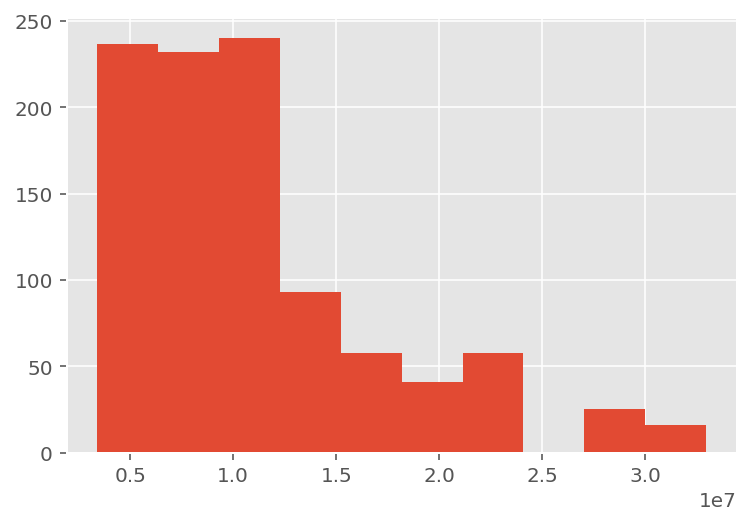

In [17]:
sensitivity_df.OrigUnscValue.hist()

In [19]:
sensitivity_df.head(20).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
P1_Mass_Flow_Rate (kg/day),15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060
P2_Mass_Flow_Rate (kg/day),7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091
P3_Mass_Flow_Rate (kg/day),7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806
P4_Mass_Flow_Rate (kg/day),7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035
P5_Mass_Flow_Rate (kg/day),15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250
P6_Mass_Flow_Rate (kg/day),7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818
I1_Mass_Flow_Rate (kg/day),6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765
I2_Mass_Flow_Rate (kg/day),10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550
I3_Mass_Flow_Rate (kg/day),21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140
I4_Mass_Flow_Rate (kg/day),10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600


In [21]:
sensitivity_df["ResDeltaRel"] = abs(sensitivity_df["PosDeltaRes"] - sensitivity_df["NegDeltaRes"] ) / (sensitivity_df["NegDeltaRes"])
sensitivity_df["ResRelSI"] = sensitivity_df["ResDeltaRel"] / (sensitivity_df["Delta"] * 2)

In [23]:
sensitivity_df.sort_values("SI", ascending=False).T

,675,775,745,155,195,95,825,615,665,705,...,808,639,648,809,646,638,568,569,539,538
P1_Mass_Flow_Rate (kg/day),15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,...,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060,15045060
P2_Mass_Flow_Rate (kg/day),7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,...,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091,7283091
P3_Mass_Flow_Rate (kg/day),7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,...,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806,7853806
P4_Mass_Flow_Rate (kg/day),7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,...,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035,7812035
P5_Mass_Flow_Rate (kg/day),15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,...,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250,15361250
P6_Mass_Flow_Rate (kg/day),7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,...,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818,7110818
I1_Mass_Flow_Rate (kg/day),6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,...,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765,6819765
I2_Mass_Flow_Rate (kg/day),10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,...,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550,10113550
I3_Mass_Flow_Rate (kg/day),21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,...,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140,21964140
I4_Mass_Flow_Rate (kg/day),10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,...,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600,10778600


In [24]:
sensitivity_df.Varied.value_counts()

P5_Mass_Flow_Rate (kg/day)    100
P6_Mass_Flow_Rate (kg/day)    100
P2_Mass_Flow_Rate (kg/day)    100
P4_Mass_Flow_Rate (kg/day)    100
P3_Mass_Flow_Rate (kg/day)    100
I4_Mass_Flow_Rate (kg/day)    100
P1_Mass_Flow_Rate (kg/day)    100
I2_Mass_Flow_Rate (kg/day)    100
I1_Mass_Flow_Rate (kg/day)    100
I3_Mass_Flow_Rate (kg/day)    100
Name: Varied, dtype: int64

0.12001944943475575 0.873885148537241
I1_Mass_Flow_Rate (kg/day) 0.470237842734758
I2_Mass_Flow_Rate (kg/day) 0.49120530636580184
I3_Mass_Flow_Rate (kg/day) 0.4694242394676353
I4_Mass_Flow_Rate (kg/day) 0.48660083408056565
P1_Mass_Flow_Rate (kg/day) 0.7050012576169677
P2_Mass_Flow_Rate (kg/day) 0.6188244067279378
P3_Mass_Flow_Rate (kg/day) 0.6365935095675234
P4_Mass_Flow_Rate (kg/day) 0.634341384953152
P5_Mass_Flow_Rate (kg/day) 0.7343175987988976
P6_Mass_Flow_Rate (kg/day) 0.748732470776357


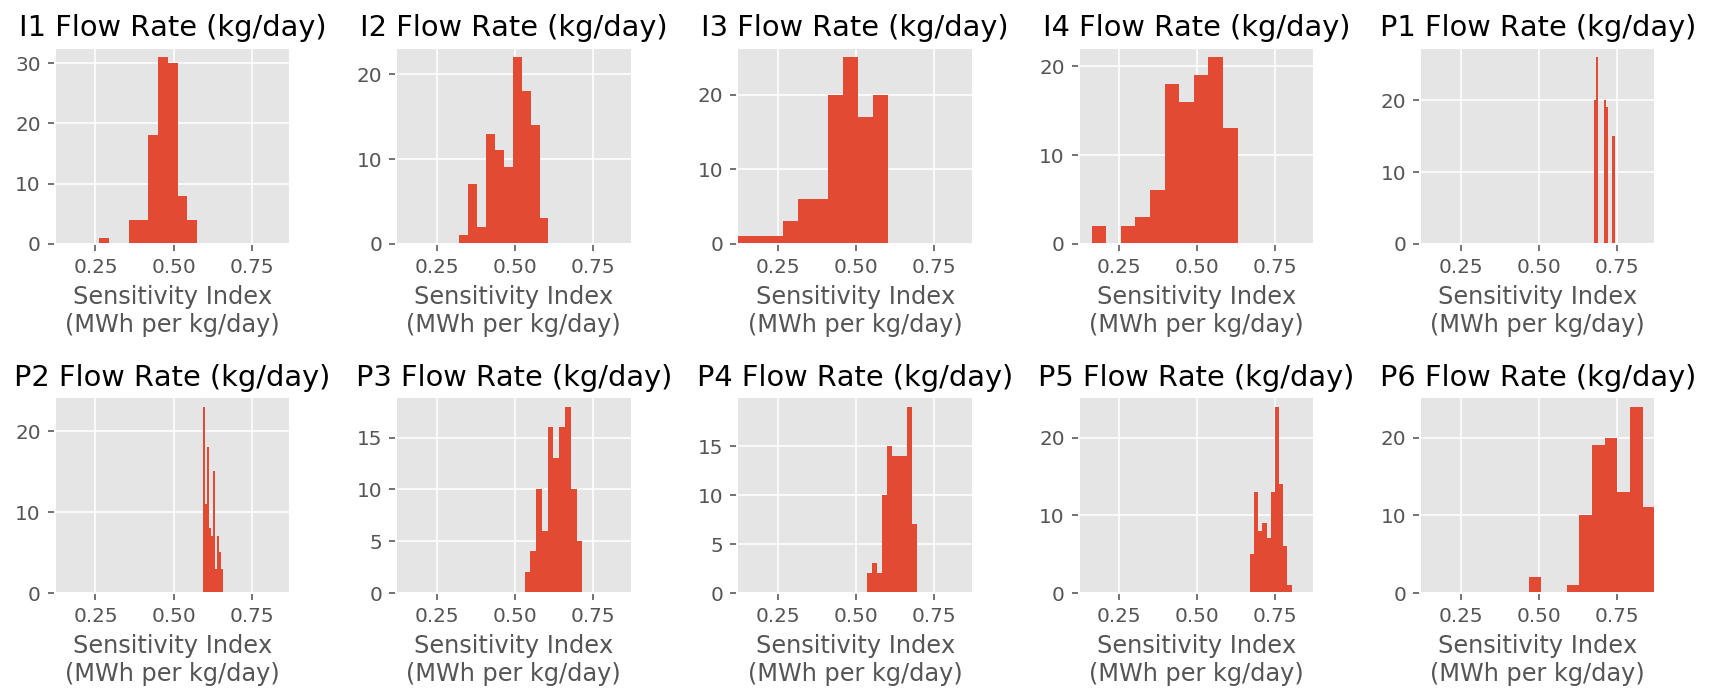

In [25]:
# Sensitivity Index

xmin = sensitivity_df["SI"].min()
xmax = sensitivity_df["SI"].max()
print(xmin, xmax)

f,a = plt.subplots(2,5, figsize=(12,5))
a = a.ravel()
for idx, (ax, q) in enumerate(zip(a, sorted(sensitivity_df.Varied.unique()))):
    vals = sensitivity_df[sensitivity_df.Varied == q]["SI"]
    ax.hist(vals)
    ax.set_title(q.replace("_", " ").replace("Mass ", ""))
    ax.set_xlabel("Sensitivity Index\n(MWh per kg/day)")
    ax.set_xlim([xmin, xmax])
    print(q, vals.mean())
plt.tight_layout()
plt.savefig("../figures/" + "SI_osr.png", dpi=300)
plt.show()

0.038242864126663195 0.8375828479018405
I1_Mass_Flow_Rate (kg/day) 0.14466633977545384
I2_Mass_Flow_Rate (kg/day) 0.22240663620172266
I3_Mass_Flow_Rate (kg/day) 0.4431198011570108
I4_Mass_Flow_Rate (kg/day) 0.22651216198153865
P1_Mass_Flow_Rate (kg/day) 0.4071087383856672
P2_Mass_Flow_Rate (kg/day) 0.18346642127180124
P3_Mass_Flow_Rate (kg/day) 0.20974196863863187
P4_Mass_Flow_Rate (kg/day) 0.20236238548490307
P5_Mass_Flow_Rate (kg/day) 0.482973635734567
P6_Mass_Flow_Rate (kg/day) 0.22448590107344835


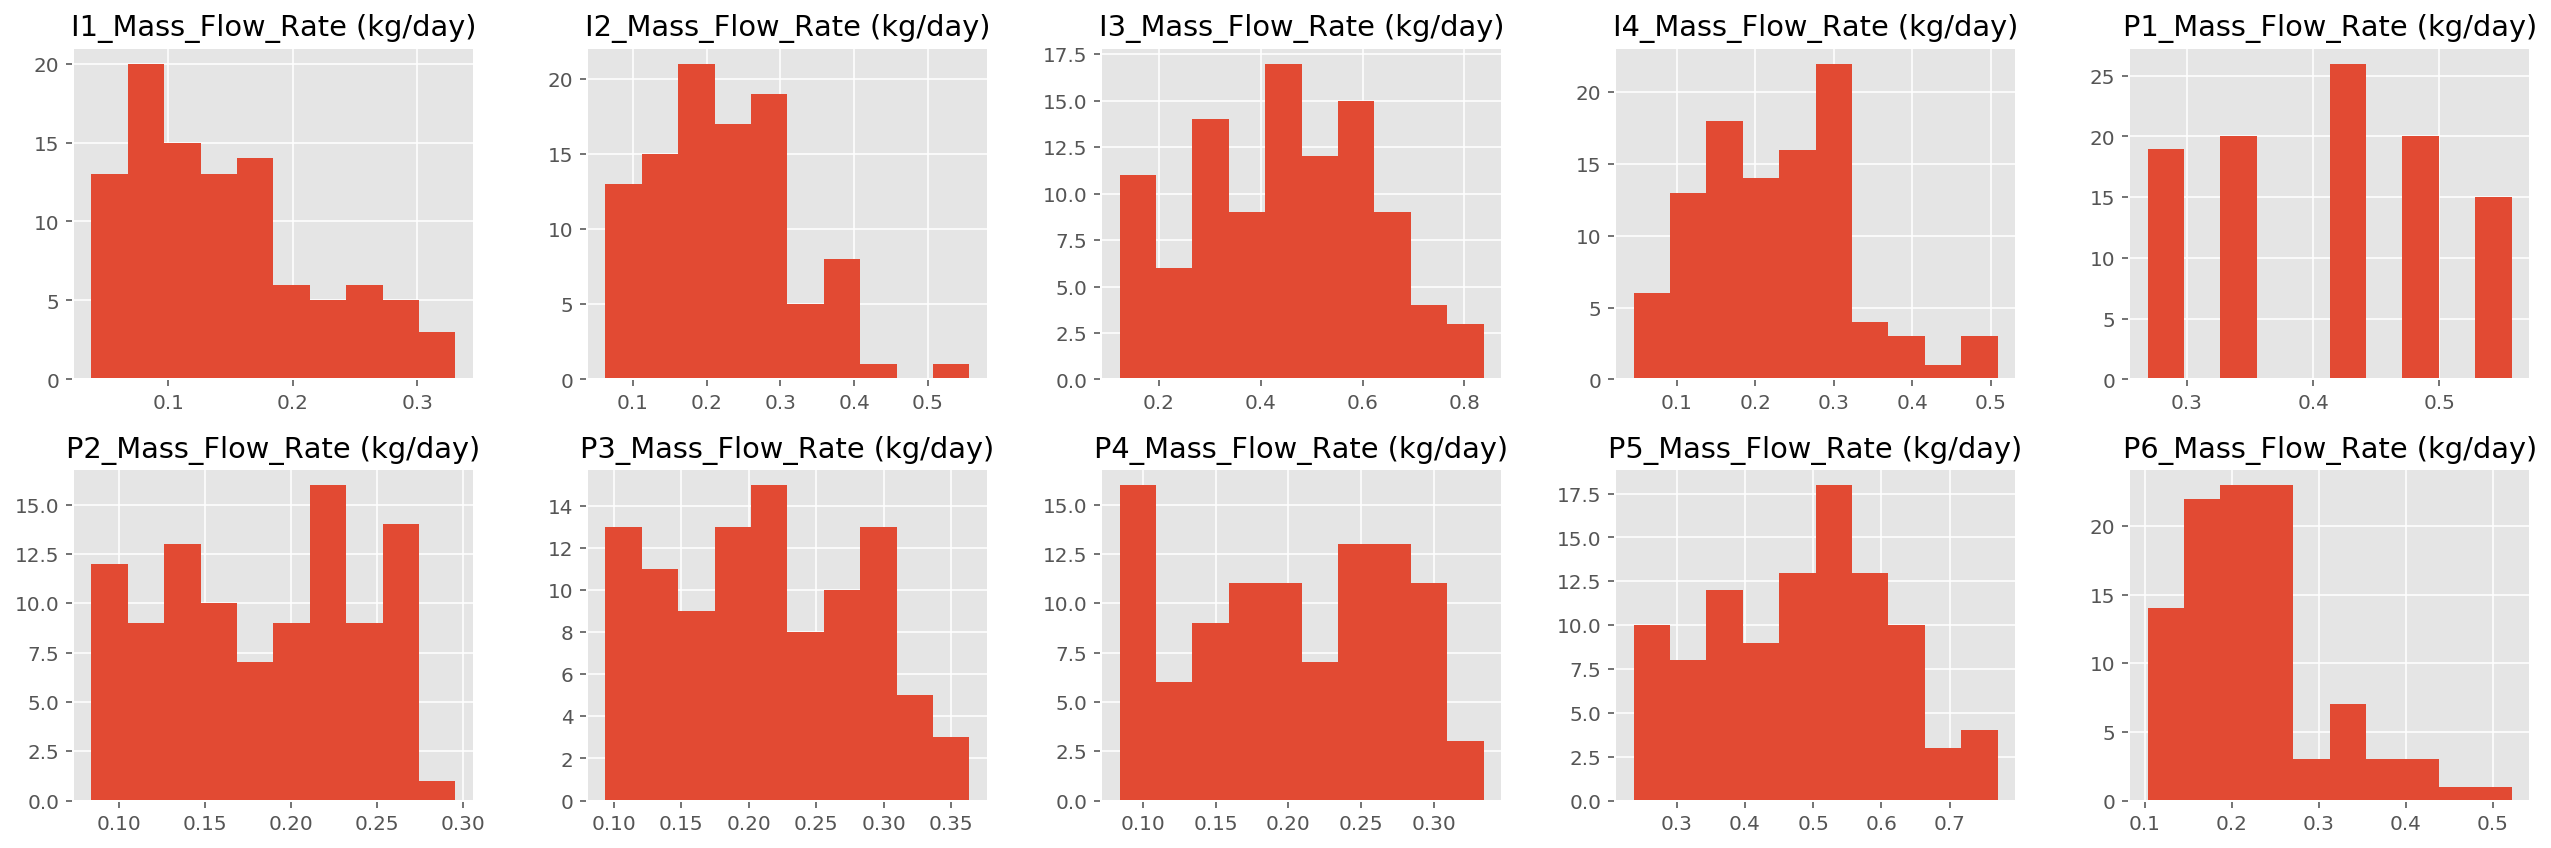

In [26]:
# Relative senstivity: % response / % change in input

print(sensitivity_df["ResRelSI"].min(), sensitivity_df["ResRelSI"].max())
f,a = plt.subplots(2,5, figsize=(18,6))
a = a.ravel()
for idx, (ax, q) in enumerate(zip(a, sorted(sensitivity_df.Varied.unique()))):
    vals = sensitivity_df[sensitivity_df.Varied == q]["ResRelSI"]
    ax.hist(vals)
    ax.set_title(q)
    print(q, vals.mean())
plt.tight_layout()

In [31]:
all_wells_df_unscaled.melt()

,variable,value
0,im1,6.81976e+06
1,im1,6819764
2,im1,6819764
3,im1,5114823
4,im1,10229650
...,...,...
1005,pm6,7110813
1006,pm6,8888509
1007,pm6,3555402
1008,pm6,8888508


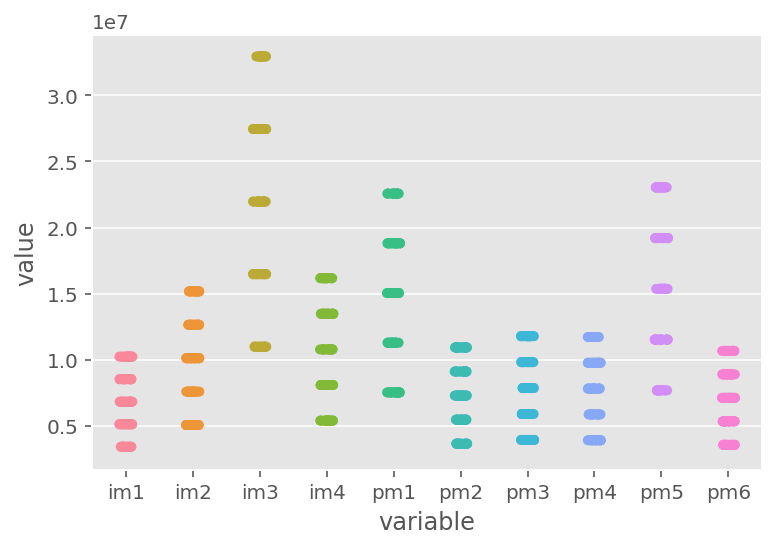

In [32]:
sns.stripplot(x="variable", y="value", data=all_wells_df_unscaled.melt())
plt.show()